In [1]:
import yaml
import cv2
import matplotlib.pyplot as plt
from types import SimpleNamespace
import numpy as np
import os
import matplotlib as mpl
import pandas as pd
import json
import umap.umap_ as umap
import rasterio
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from adjustText import adjust_text
from matplotlib.colors import ListedColormap
from scipy.stats import percentileofscore
from sklearn.decomposition import PCA

mpl.rcParams['pdf.fonttype'] = 42

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def create_folder(file_path):
    if not os.path.exists(file_path):
        os.makedirs(file_path)

def cov_center(data, level=0.95):
    env = EllipticEnvelope(support_fraction=level).fit(data)
    center = env.location_
    covariance = env.covariance_
    return center, covariance

def plot_ellipse(center, covariance, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    在给定的轴上绘制一个椭圆。

    :param center: 椭圆的中心点。
    :param covariance: 椭圆的协方差矩阵。
    :param ax: matplotlib 轴对象。
    :param n_std: 确定椭圆大小的标准差倍数。
    :param facecolor: 椭圆的填充颜色。
    :param kwargs: 传递给 Ellipse 对象的其他参数。
    """
    # 计算协方差矩阵的特征值和特征向量
    eigenvals, eigenvecs = np.linalg.eigh(covariance)
    order = eigenvals.argsort()[::-1]
    eigenvals, eigenvecs = eigenvals[order], eigenvecs[:, order]

    # 计算椭圆的宽度和高度
    width, height = 2 * n_std * np.sqrt(eigenvals)
    angle = np.degrees(np.arctan2(*eigenvecs[:,0][::-1]))

    # 创建并添加椭圆形状
    ellipse = Ellipse(xy=center, width=width, height=height, angle=angle, facecolor=facecolor, **kwargs)
    ax.add_patch(ellipse)
    
def png_operation(rst):
    grid_normalized = cv2.normalize(rst, None, 0, 255, cv2.NORM_MINMAX)
    grid_uint8 = grid_normalized.astype(np.uint8)
    colored_image = cv2.applyColorMap(grid_uint8, cv2.COLORMAP_JET)
    # 設定要調整的尺寸，例如 300x300
    new_size = (300, 300)
    # 調整 PNG 的大小
    resized_png = cv2.resize(colored_image, new_size, interpolation=cv2.INTER_CUBIC)
    return resized_png

# 計算兩個經緯度點之間的距離，支持向量化操作
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # 地球半徑，單位：公里
    lat1, lon1 = np.radians(lat1), np.radians(lon1)
    lat2, lon2 = np.radians(lat2), np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

In [3]:
run_id = 'e52c8ac9a3e24c75ac871f63bbdea060'
exp_id = '115656750127464383'
conf_path = os.path.join('mlruns', exp_id, run_id, 'artifacts', 'conf')
predicts_path = os.path.join('predicts', run_id)

# DeepSDM configurations
DeepSDM_conf_path = os.path.join(conf_path, 'DeepSDM_conf.yaml')
with open(DeepSDM_conf_path, 'r') as f:
    DeepSDM_conf = SimpleNamespace(**yaml.load(f, Loader = yaml.FullLoader))
    
# load extent binary map
with rasterio.open(os.path.join(conf_path, 'extent_binary.tif'), 'r') as f:
    transform = f.transform
    height, width = f.shape
    lon_min, lat_max = rasterio.transform.xy(transform, 0, 0)  # 左上角
    lon_max, lat_min = rasterio.transform.xy(transform, height - 1, width - 1)  # 右下角
    extent_binary = f.read(1)
extent_binary_extent = [lon_min, lon_max, lat_min, lat_max]
    
# species occurrence points
with open(os.path.join(predicts_path, 'sp_inf.json'), 'r') as f:
    sp_inf = json.load(f)
with open(os.path.join(conf_path, 'cooccurrence_vector.json')) as f:
    coocc_vector = json.load(f)
with open(os.path.join(conf_path, 'env_information.json')) as f:
    env_info = json.load(f)
    
# create a plot folder of the specific exp_id
plot_path_embedding_dimension_reduction = os.path.join('plots', run_id, 'Fig2_embedding_dimension_reduction')
create_folder(plot_path_embedding_dimension_reduction)

In [4]:
species_list_train = sorted(DeepSDM_conf.training_conf['species_list_train'])

date_list_predict = DeepSDM_conf.training_conf['date_list_predict']
date_list_train = DeepSDM_conf.training_conf['date_list_train']

deepsdm_h5_path = os.path.join('predicts', run_id, 'h5', '[SPECIES]', '[SPECIES].h5')
maxent_h5_path = os.path.join('predict_maxent', run_id, 'h5', 'all', '[SPECIES]', '[SPECIES].h5')

In [5]:
species_occ = pd.read_csv(DeepSDM_conf.cooccurrence_conf['sp_filter_from'])

In [6]:
# 初始化物種平均海拔字典
species_avg_elevation = {}

# 讀取海拔數據
elev_path = os.path.join(env_info['dir_base'], env_info['info']['elev'][date_list_train[0]]['tif_span_avg'])
with rasterio.open(elev_path, 'r') as f:
    elev_rst = f.read(1)  # 海拔數據

# 為每個物種計算平均海拔
for i, sp in enumerate(species_list_train):
    print(f'{i} {sp}\r', end = '')
    # 過濾出當前物種的出現記錄
    occ_sp = species_occ[species_occ.species == sp]

    # 將緯經度轉換為影像索引
    rows, cols = rasterio.transform.rowcol(
        transform,
        occ_sp['decimalLongitude'].values,
        occ_sp['decimalLatitude'].values
    )

    # 獲取對應位置的海拔值
    elevations = elev_rst[rows, cols]

    # 過濾無效海拔數據（如 -9999 值）
    valid_elevations = np.where(elevations == -9999, np.nan, elevations)

    # 計算平均海拔
    if len(valid_elevations) > 0:
        species_avg_elevation[sp] = np.nanmean(valid_elevations)
    else:
        species_avg_elevation[sp] = None  # 如果沒有有效數據，設置為 None

# 將結果轉為 DataFrame（選擇性）
avg_elevation_df = pd.DataFrame.from_dict(
    species_avg_elevation, orient='index', columns=['AverageElevation']
)
avg_elevation_df.reset_index(inplace=True)
avg_elevation_df.rename(columns={'index': 'Species'}, inplace=True)

# 輸出結果
print(avg_elevation_df)
avg_elevation_df.to_csv(os.path.join(plot_path_embedding_dimension_reduction, 'avg_elevation.csv'), index = None)

                       Species  AverageElevation
0       Abroscopus_albogularis       1391.549805
1        Accipiter_trivirgatus        287.942932
2           Accipiter_virgatus        427.538818
3    Acridotheres_cristatellus         45.512520
4      Actinodura_morrisoniana       2019.975952
..                         ...               ...
120          Urocissa_caerulea        258.378876
121         Yuhina_brunneiceps       1752.611206
122    Yungipicus_canicapillus        408.490295
123             Zoothera_dauma       1543.271606
124          Zosterops_simplex        200.117386

[125 rows x 2 columns]


## 物種共域向量

## 分群

In [7]:
# all species
# species list
sp_all = [sp for sp in sorted(coocc_vector)]

# embedding list
vec_all = [coocc_vector[sp] for sp in sorted(coocc_vector)]

# dataframe of all species
df_vec_all = pd.DataFrame(vec_all)

In [8]:
# used species (species used for prediction)
# species list
vec = [coocc_vector[species] for species in species_list_train]

# dataframe of all species
df_vec = pd.DataFrame(vec)

### 依照海拔上色
 - UMAP降維

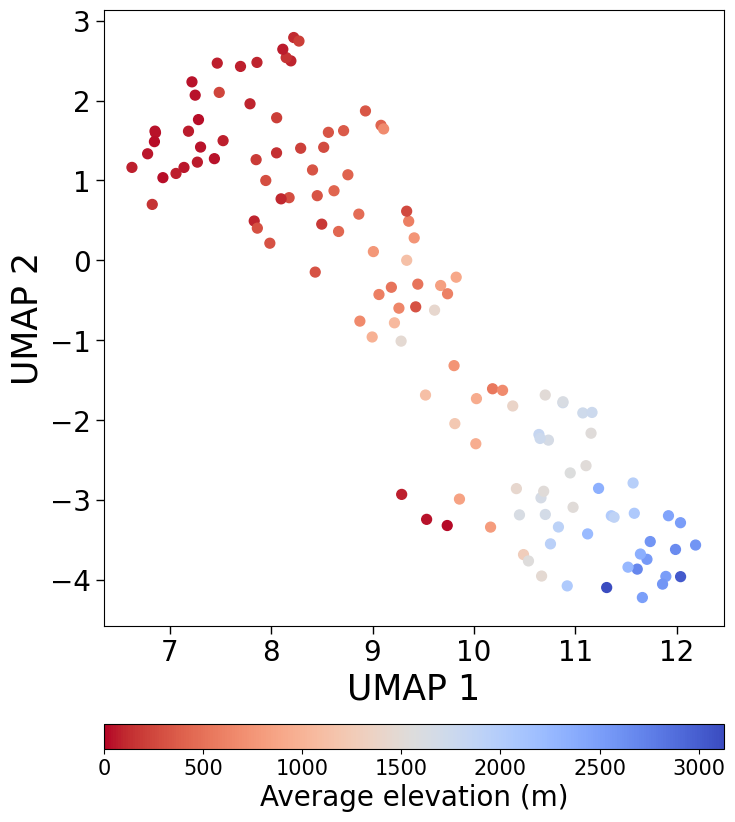

In [13]:
n_clusters= 3
reducer = umap.UMAP(n_neighbors =  22, n_components=2, random_state=42, n_jobs = 1)
embedding_umap = reducer.fit_transform(df_vec.values)

embedding_kmeans_fun = KMeans(n_clusters = n_clusters, random_state = 42, n_init = 'auto')
embedding_kmeans_result = embedding_kmeans_fun.fit(df_vec.values)

# 建立圖形
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot()

    
# 提取 elev_info 對應於 species_list_train 中的有效值
elev_values = [species_avg_elevation[sp] for sp in species_list_train]
umap_values = [embedding_umap[i] for i, sp in enumerate(species_list_train)]

umap_values = np.array(umap_values)  # 轉換成 numpy 陣列

# 繪製散布圖
ax_scatter = ax.scatter(umap_values[:, 0], umap_values[:, 1], c=elev_values, cmap='coolwarm_r', s=50, vmin = 0)
# for sp in ['Carpodacus_formosanus', 'Trochalopteron_morrisonianum', 'Yuhina_brunneiceps', 'Psilopogon_nuchalis', 'Liocichla_steerii']:
#     idx = species_list_train.index(sp)
#     ax.scatter(umap_values[idx, 0], umap_values[idx, 1], color = 'black')

# 設置標籤和格式
ax.set_xlabel('UMAP 1', fontsize=25)
ax.set_ylabel('UMAP 2', fontsize=25)
ax.tick_params(axis='both', which='both', length=6, width=1)  # 調整長度和寬度
ax.tick_params(axis='both', labelsize=20)  # 設置 x 軸刻度標籤字體大小
ax_pos = ax.get_position()
cbar_ax = fig.add_axes([ax_pos.x0, 
                        ax_pos.y0 - ax_pos.height*0.2, 
                        ax_pos.width*1, 
                        ax_pos.height*0.04])
cbar = fig.colorbar(ax_scatter, ax = ax, orientation='horizontal', cax = cbar_ax)
cbar.ax.tick_params(labelsize=15)  # 調整刻度標籤字體大小
cbar.set_label('Average elevation (m)', fontsize = 20)

# xticks = [3,4,5,6]
# ax.set_xticks(np.array(xticks))

plt.savefig(os.path.join(plot_path_embedding_dimension_reduction, 'embedding_umap_elev.pdf'), dpi=200,  bbox_inches='tight', transparent = True)

# plt.show()

 - PCA 降維

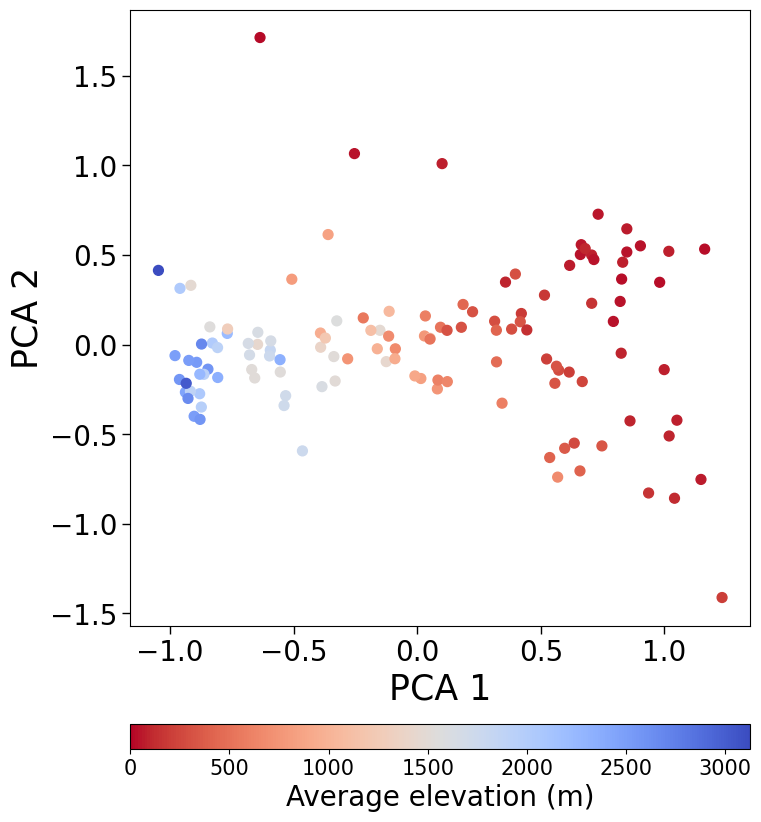

In [14]:
# PCA 降維
n_clusters = 3
pca = PCA(n_components=2, random_state=42)
embedding_pca = pca.fit_transform(df_vec.values)

# KMeans 分群
embedding_kmeans_fun = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
embedding_kmeans_result = embedding_kmeans_fun.fit(df_vec.values)

# 建立圖形
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot()

# 提取 elev_info 對應於 species_list_train 中的有效值
elev_values = [species_avg_elevation[sp] for sp in species_list_train]
pca_values = [embedding_pca[i] for i, sp in enumerate(species_list_train)]

pca_values = np.array(pca_values)  # 轉換成 numpy 陣列

# 繪製散布圖
ax_scatter = ax.scatter(pca_values[:, 0], pca_values[:, 1], c=elev_values, cmap='coolwarm_r', s=50, vmin=0)

# for sp in ['Carpodacus_formosanus', 'Trochalopteron_morrisonianum', 'Yuhina_brunneiceps', 'Psilopogon_nuchalis', 'Liocichla_steerii']:
#     idx = species_list_train.index(sp)
#     ax.scatter(pca_values[idx, 0], pca_values[idx, 1], color='black')

# 設置標籤和格式
ax.set_xlabel('PCA 1', fontsize=25)
ax.set_ylabel('PCA 2', fontsize=25)
ax.tick_params(axis='both', which='both', length=6, width=1)  # 調整長度和寬度
ax.tick_params(axis='both', labelsize=20)  # 設置 x 軸刻度標籤字體大小
ax_pos = ax.get_position()
cbar_ax = fig.add_axes([ax_pos.x0, 
                        ax_pos.y0 - ax_pos.height*0.2, 
                        ax_pos.width*1, 
                        ax_pos.height*0.04])
cbar = fig.colorbar(ax_scatter, ax=ax, orientation='horizontal', cax=cbar_ax)
cbar.ax.tick_params(labelsize=15)  # 調整刻度標籤字體大小
cbar.set_label('Average elevation (m)', fontsize=20)

# 保存圖像
plt.savefig(os.path.join(plot_path_embedding_dimension_reduction, 'embedding_pca_elev.pdf'), dpi=200, bbox_inches='tight', transparent=True)

# 顯示圖像
# plt.show()


### 目前沒用到

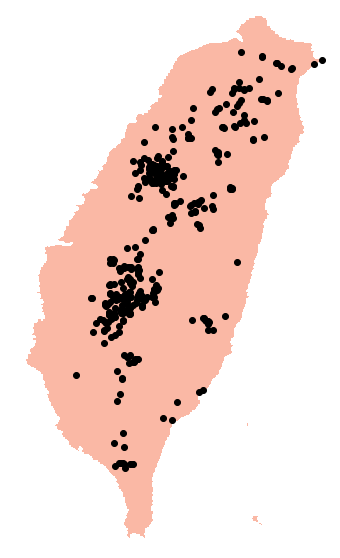

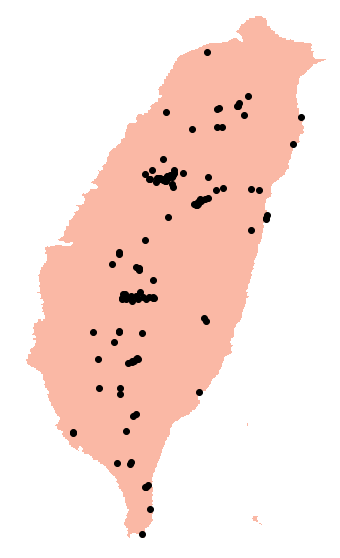

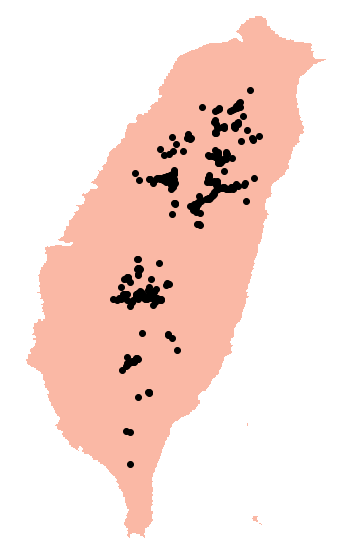

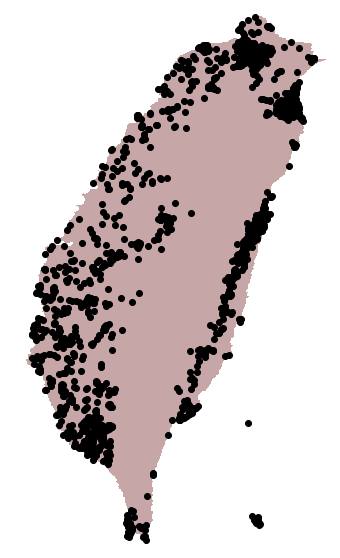

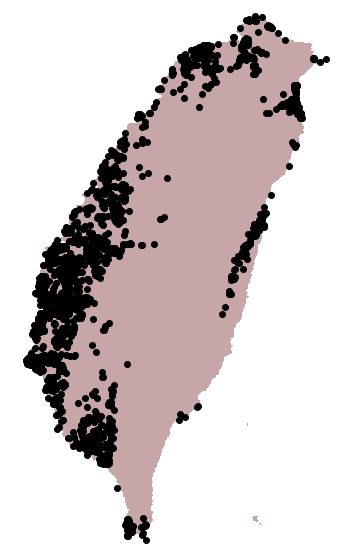

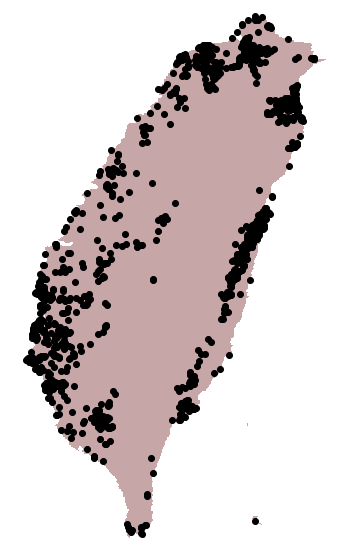

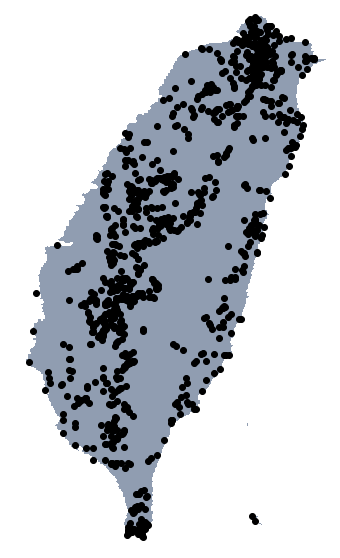

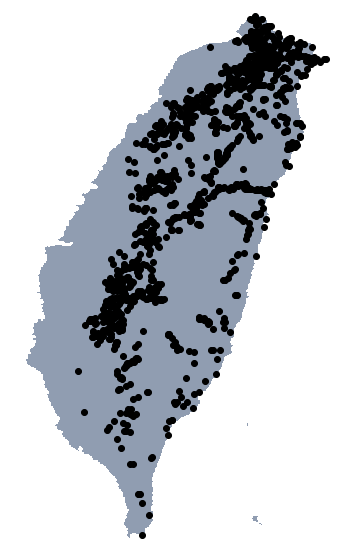

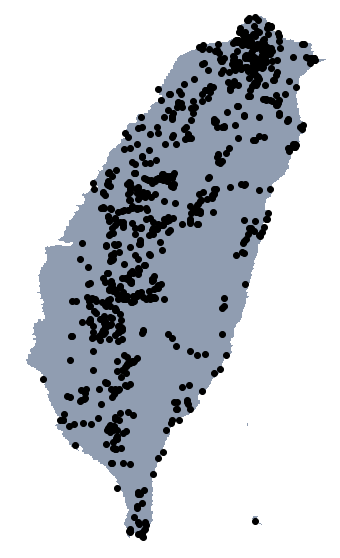

In [12]:
cmap_expand = [color for color in cmap for _ in range(3)]

for i, species in enumerate(special_species):
    sp_img = None
    for time in date_list_train:
        occ_path = os.path.join(sp_inf['dir_base'], sp_inf['file_name'][species][time])
        if os.path.exists(occ_path):
            with rasterio.open(occ_path, 'r') as f:
                if sp_img is None:
                    sp_img = f.read(1)
                else:
                    sp_img = sp_img + f.read(1)
    sp_img = np.where(extent_binary == 0, np.nan, np.sign(sp_img))
    lon_all, lat_all = rasterio.transform.xy(transform, np.where(sp_img == 1)[0], np.where(sp_img == 1)[1], offset='center')
    #     break
    fig, ax = plt.subplots(1, 1, figsize = (6, 10))
    ax.imshow(sp_img, cmap = ListedColormap([cmap_expand[i]]), extent = extent_binary_extent, alpha = 0.5)
    ax.scatter(lon_all, lat_all, c = 'black')
#     ax.spines['all'].set_visible(False)
#     ax.spines['top'].set_visible(False)
#     ax.set_ylabel('latitude', fontsize = 25)
#     ax.set_xlabel('longitude', fontsize = 25)
    ax.axis('off')
    ax.tick_params(axis='both', labelsize=15)  # 設置 x 軸刻度標籤字體大小
    ax.tick_params(axis='both', which='both', length=8, width=2)  # 調整長度和寬度
#     ax.set_title(f"{species.replace('_', ' ')}", fontsize = 50, fontstyle = 'italic')
#     plt.savefig(os.path.join(plot_path_embedding_dimension_reduction, f'occ_{species}.png'), dpi=200)

### 計算特定物種組合的距離在前X%

In [61]:
# species_list_train 與 df_vec 的行數相同，且名稱按順序對應
df_vec.index = species_list_train

# 計算距離矩陣（以歐幾里得距離為例）
distance_matrix = pd.DataFrame(
    np.linalg.norm(df_vec.values[:, np.newaxis] - df_vec.values, axis=2),
    index=species_list_train,
    columns=species_list_train
)

# 查看結果
distance_matrix.head()

,Abroscopus_albogularis,Accipiter_trivirgatus,Accipiter_virgatus,Acridotheres_cristatellus,Actinodura_morrisoniana,Aegithalos_concinnus,Alauda_gulgula,Alcippe_brunnea,Alcippe_morrisonia,Amaurornis_phoenicurus,...,Troglodytes_troglodytes,Turdus_poliocephalus,Turnix_suscitator,Turnix_sylvaticus,Tyto_longimembris,Urocissa_caerulea,Yuhina_brunneiceps,Yungipicus_canicapillus,Zoothera_dauma,Zosterops_simplex
Abroscopus_albogularis,0.000000,1.216624,1.267280,1.664357,0.997109,0.562276,1.573668,1.047660,1.086579,1.437454,...,1.443385,1.454203,2.098032,2.019591,1.814527,2.371425,1.071596,2.578399,1.376631,2.678875
Accipiter_trivirgatus,1.216624,0.000000,0.894559,1.290028,1.404627,1.258454,1.137886,1.124539,0.956296,1.000621,...,1.716627,1.736590,1.758447,2.000519,1.674615,2.086608,1.740523,2.403911,1.661900,2.362600
Accipiter_virgatus,1.267280,0.894559,0.000000,1.337723,1.407966,1.311769,1.245822,1.097291,0.908683,1.132165,...,1.679189,1.794478,1.854344,2.002668,1.789675,2.062638,1.763235,2.580193,1.724833,2.610701
Acridotheres_cristatellus,1.664357,1.290028,1.337723,0.000000,1.876782,1.760056,1.255516,1.506802,1.444241,1.066342,...,2.255751,2.131417,1.897741,2.082007,1.924335,2.289525,2.186605,2.760283,2.173783,2.630000
Actinodura_morrisoniana,0.997109,1.404627,1.407966,1.876782,0.000000,0.808729,1.744576,1.356852,1.313892,1.681787,...,1.109165,1.292732,2.366831,1.894815,1.696240,2.532044,1.550396,2.694047,1.157310,2.856897


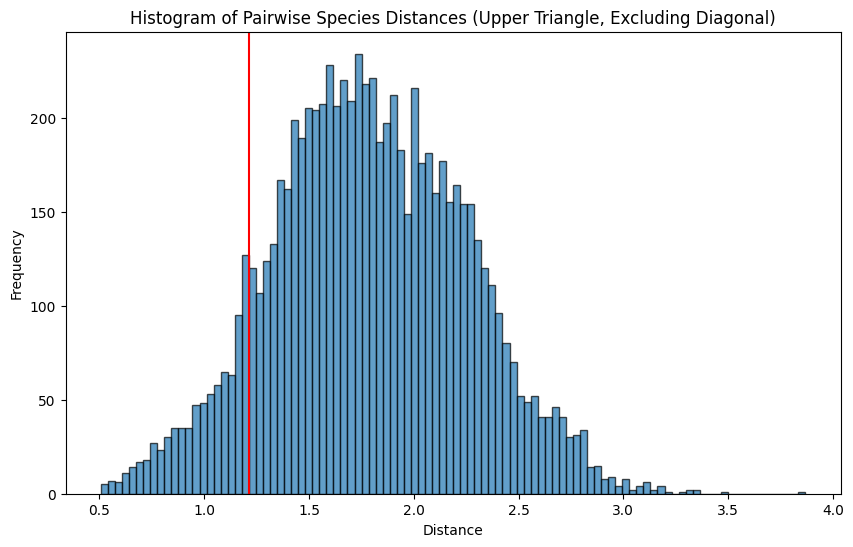

In [62]:
# 創建布林值的上三角遮罩矩陣（排除對角線）
mask = np.triu(np.ones(distance_matrix.shape), k=1).astype(bool)

# 使用遮罩選取上三角的非對角線元素
upper_triangle_values = distance_matrix.where(mask).stack().values

min_d = 10
# 繪製距離的直方圖
plt.figure(figsize=(10, 6))
plt.hist(upper_triangle_values, bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Pairwise Species Distances (Upper Triangle, Excluding Diagonal)')
plt.axvline(distance_matrix['Psilopogon_nuchalis']['Hypsipetes_leucocephalus'], color = 'red')
plt.show()


In [63]:
percentile = percentileofscore(upper_triangle_values, distance_matrix['Psilopogon_nuchalis']['Hypsipetes_leucocephalus'], kind='rank')
print(f"The percentile of distance between 五色鳥 nad 紅嘴黑鵯 in the data is: {percentile}%")

The percentile of distance between 五色鳥 nad 紅嘴黑鵯 in the data is: 10.580645161290322%


### 另一個東西

In [35]:
sp_occ_raw = pd.read_csv(DeepSDM_conf.gbif_occurrence_csv, sep = '\t')

/tmp/ipykernel_4005475/2995934668.py:1: DtypeWarning: Columns (10,14,16,17,26,32,33,34,36,37,38,39,40,41,43,46,48) have mixed types. Specify dtype option on import or set low_memory=False.
  sp_occ_raw = pd.read_csv(DeepSDM_conf.gbif_occurrence_csv, sep = '\t')


In [41]:
# 参数配置
num_clusters_to_show = n_clusters  # 要显示的聚类数
rows_per_cluster = 2     # 每个聚类的行数
max_images_per_cluster = 100 # 每个聚类最多显示的图片数

# 可视化每个聚类中的TIFF图像
for cluster in range(num_clusters_to_show):
    sp_cluster = (np.array(sp_all))[embedding_kmeans_result.labels_ == cluster]
    break
    # 计算每行显示的图像数量
    images_per_row = (max_images_per_cluster + rows_per_cluster - 1) // rows_per_cluster
    
    fig, axes = plt.subplots(rows_per_cluster, images_per_row, figsize=(30, 4 * rows_per_cluster))
    fig.suptitle(f'Cluster {cluster}')
    
    for i, sp in enumerate(sp_cluster[:max_images_per_cluster]):
        row = i // images_per_row
        col = i % images_per_row
        ax = axes[row, col] if rows_per_cluster > 1 else axes[col]
        
        tiff_path = f'/home/klok0126/DeepSDM/predicts/2f07dfdd1bef43988e07f22cb2e322c5/tif/{sp}_2018-04-01_predict.tif'
        if os.path.exists(tiff_path):
            with rasterio.open(tiff_path) as src:
                img = src.read(1)
            ax.imshow(img, cmap='coolwarm')
            ax.set_title(sp)
            ax.axis('off')
        else:
            print(f"File not found: {tiff_path}")
    
    # 隐藏多余的子图
    for j in range(i + 1, rows_per_cluster * images_per_row):
        row = j // images_per_row
        col = j % images_per_row
        ax = axes[row, col] if rows_per_cluster > 1 else axes[col]
        ax.axis('off')
    
    plt.show()

In [ ]:
八哥 Acridotheres cristatellus formosanus 臺灣特有亞種
黃山雀 Machlolophus holsti Seebohm 臺灣特有種
赤腹山雀 Parus varius castaneoventris Gould 臺灣特有種
青背山雀Parus monticolus insperatus (Swinhoe) 臺灣特有亞種
煤山雀 Parus ater ptilosus Ogilvie-Grant 臺灣特有亞種
大卷尾 Dicrurus macrocercus 臺灣特有亞種
小卷尾 Dicrurus aeneus 臺灣特有亞種
台灣灰鷽 Pyrrhula erythaca 臺灣特有種
臺灣朱雀 Carpodacus formosanus 臺灣特有種
褐鷽 Pyrrhula nipalensis 臺灣特有亞種
大彎嘴 Pomatorhinus erythrogenys 臺灣特有種
小彎嘴 Pomatorhinus ruficollis 臺灣特有種
山紅頭 Stachyris ruficeps 臺灣特有亞種
金翼白眉 Trochalopteron morrisonianum (Ogilvie-Grant) 臺灣特有種
白耳畫眉 Heterophasia auricularis (Swinhoe) 臺灣特有種
臺灣白喉噪眉 Ianthocincla ruficeps (Gould, 1863) 臺灣特有種
褐頭花翼 Fulvetta formosana 臺灣特有種
冠羽畫眉 Yuhina brunneiceps Ogilvie-Grant 臺灣特有種
紋翼畫眉 Actinodura morrisoniana Ogilvie-Grant 臺灣特有種
竹鳥 Garrulax poecilorhynchus poecilorhynchus Gould 臺灣特有種
臺灣畫眉 Leucodioptron taewanum（Garrulax canorus taewanus Swinhoe）臺灣特有種
黃胸藪眉 Liocichla steerii Swinhoe 臺灣特有種
頭烏線 Alcippe brunnea 臺灣特有亞種
繡眼畫眉 Alcippe morrisonia 臺灣特有種
岩鷚 Prunella collaris 臺灣特有亞種
紅胸啄花鳥 Dicaeum ignipectus 臺灣特有亞種
綠啄花鳥 Dicaeum concolor 臺灣特有亞種
朱鸝 Oriolus traillii ardens (Swinhoe) 臺灣特有亞種
臺灣藍鵲 Urocissa caerulea (Gould) 臺灣特有種
松鴉 Garrulus glandarius taivnus Gould 臺灣特有亞種
星鴉 Nucifraga caryocatactes owstoni (Ingram, 1910) 臺灣特有亞種
樹鵲 Dendrocitta formosae formosae 臺灣特有亞種
白頭翁 Pycnonotus sinensis formosae 臺灣特有亞種
白環鸚嘴鵯 Spizixos semitorques 臺灣特有亞種
紅嘴黑鵯 Hypsipetes leucocephalus nigerrimus 臺灣特有亞種
烏頭翁 Pycnonotus taivanus 臺灣特有種
棕耳鵯 Hypsipetes amaurotis 臺灣特有亞種
小剪尾 Enicurus scouleri fortis (Hartert) 臺灣特有亞種
小翼鶇 Brachypteryx montana Ogilvie-Grant 臺灣特有種
臺灣紫嘯鶇 Myiophoneus insularis Gould 臺灣特有種
白尾鴝 Cinclidium leucurum montium (Swinhoe) 臺灣特有亞種
台灣白眉林鴝 Tarsiger formosanus 臺灣特有種
栗背林鴝 Tarsiger johnstoniae (Ogilvie-Grant) 臺灣特有種
鉛色水鶇 Phoenicurus 臺灣特有亞種
白頭鶇 Turdus poliocephalus niveiceps (Hellmayr) 臺灣特有種
火冠戴菊鳥 Regulus goodfellowi Ogilvie-Grant 臺灣特有種
茶腹鳾 Sitta europaea (Verreaux, 1871) 臺灣特有亞種
深山鶯 Horornis acanthizoides 臺灣特有亞種
小鶯 Horornis fortipes robustipes 臺灣特有亞種
斑紋鷦鶯 Prinia criniger 臺灣特有亞種
黃頭扇尾鶯 Cisticola exills 臺灣特有亞種
褐頭鷦鶯 Prinia inornata flavirostris 臺灣特有亞種
黃胸青鶲 Ficedula hyperythra innexa (Swinhoe) 臺灣特有亞種
黃腹琉璃Niltava vivida (Swinhoe) 臺灣特有種
黑枕藍鶲 Hypothymis azurea oberholseri 臺灣特有亞種
臺灣短翅鶯 Locustella alishanensis 臺灣特有種
鷦鷯 Troglodytes troglodytes taivanus 臺灣特有亞種
粉紅鸚嘴 Sinosuthora webbiana bulomacha 臺灣特有亞種
黃羽鸚嘴 Suthora verreauxi morrisoniana 臺灣特有亞種
臺灣鷦眉 Pnoepyga formosana 臺灣特有種

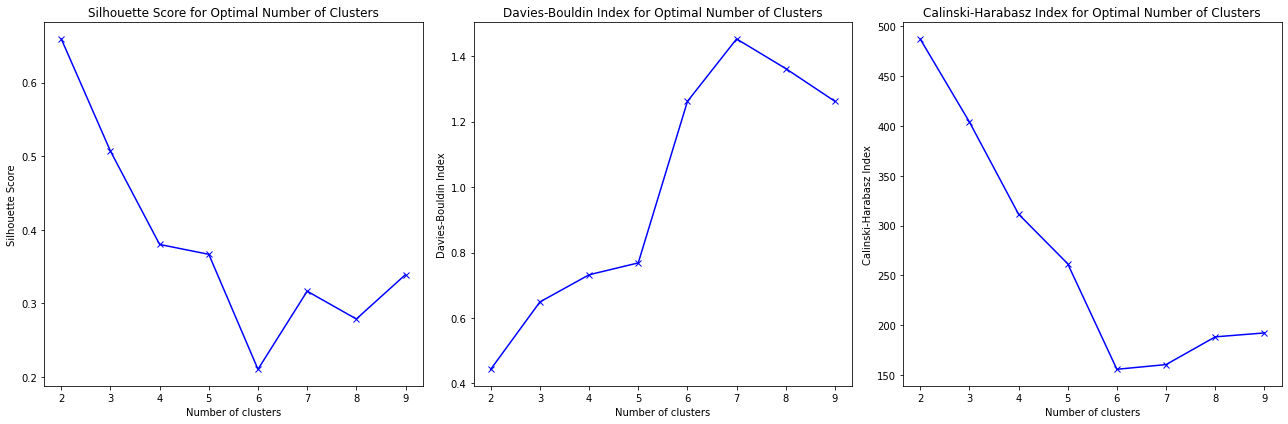

In [34]:
# data
data = df_vec.copy()
reducer = umap.UMAP(n_neighbors = 15, n_components=3, random_state=42, n_jobs = 1)
data = reducer.fit_transform(data.values)

# Define the range of clusters to evaluate
K = range(2, 10)

# Initialize lists to store the scores for each number of clusters
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

# Evaluate clustering for each number of clusters
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=1000)
    labels = kmeans.fit_predict(df_vec)
    
    # Calculate Silhouette Score
    silhouette_scores.append(silhouette_score(data, labels))
    
    # Calculate Davies-Bouldin Index
    davies_bouldin_scores.append(davies_bouldin_score(data, labels))
    
    # Calculate Calinski-Harabasz Index
    calinski_harabasz_scores.append(calinski_harabasz_score(data, labels))

# Plot the scores
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Number of Clusters')

plt.subplot(1, 3, 2)
plt.plot(K, davies_bouldin_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index for Optimal Number of Clusters')

plt.subplot(1, 3, 3)
plt.plot(K, calinski_harabasz_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index for Optimal Number of Clusters')

plt.tight_layout()
plt.show()


center : [ 8.909735  -1.2068111]
0 . Lophura swinhoii
0 . Turdus poliocephalus
0 . Sitta europaea
center : [4.7276554 1.331623 ]
1 . Amaurornis phoenicurus
1 . Elanus caeruleus
1 . Lanius schach
center : [6.610919  1.0845948]
2 . Pernis ptilorhynchus
2 . Myophonus insularis
2 . Accipiter virgatus


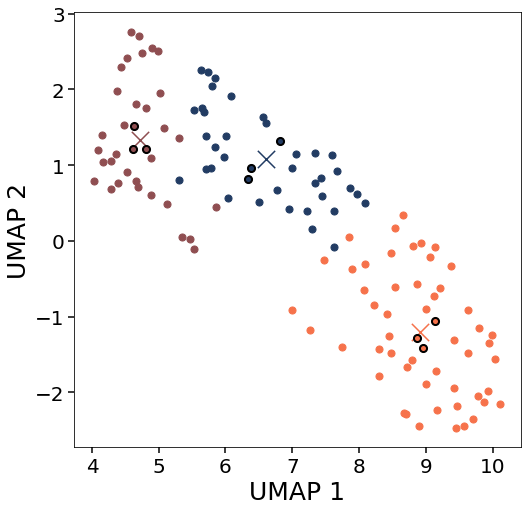

In [9]:
n_clusters= 3
reducer = umap.UMAP(n_neighbors =  50, n_components=2, random_state=42, n_jobs = 1)
embedding_umap = reducer.fit_transform(df_vec.values)

embedding_kmeans_fun = KMeans(n_clusters = n_clusters, random_state = 42, n_init = 'auto')
embedding_kmeans_result = embedding_kmeans_fun.fit(df_vec.values)

# 計算每個類群的中心點（即平均位置）
centroids = np.array([embedding_umap[embedding_kmeans_result.labels_ == i].mean(axis=0) for i in range(n_clusters)])

# 建立圖形
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot()
cmap = ['#F6724B', '#8F4E51', '#223C63']
shape = ['.', '.', '.']

special_species = []

# 用於儲存所有文本標註的物件，稍後調整它們的位置
texts = []

# 標註中心點
for i, centroid in enumerate(centroids):
    ax.scatter(centroid[0], centroid[1], color=cmap[i], s=300, marker='x')  # 用 'x' 表示類群中心點
    
# 計算每個群組內距離中心點最近的 3 個物種
for cluster_idx in range(n_clusters):
    # 取得該類群內的所有點的 index
    cluster_indices = np.where(embedding_kmeans_result.labels_ == cluster_idx)[0]
    cluster_points = embedding_umap[cluster_indices]
    print(f'center : {centroids[cluster_idx]}')
    species_in_cluster = np.array(species_list_train)[cluster_indices]

    # 計算該類群內所有點到中心點的距離
    distances = cdist(cluster_points, centroids[cluster_idx].reshape(1, -1), metric='euclidean').flatten()

    # 排序並選擇距離中心最近的 3 個物種
    closest_points_indices = np.argsort(distances)[:3]
    
    # 在圖中畫出所有的點
    for i, sp in enumerate(species_list_train):
        if embedding_kmeans_result.labels_[i] == cluster_idx:
            ax.scatter(embedding_umap[i, 0], embedding_umap[i, 1], color=cmap[cluster_idx], s=50)
    
    # 在圖中標註距離中心點最近的 3 個物種，並用黑線包圍它們
    for i, idx in enumerate(closest_points_indices):
        point_idx = cluster_indices[idx]  # 獲取全局索引
        ax.scatter(embedding_umap[point_idx, 0], embedding_umap[point_idx, 1], edgecolor='black', s=200, facecolor=cmap[cluster_idx], lw=2, marker = shape[i])
#         text = ax.text(embedding_umap[point_idx, 0], embedding_umap[point_idx, 1],
#                        species_list_train[point_idx].replace('_', ' '), fontsize=15, fontstyle='italic')
#         texts.append(text)
        
        
        print(cluster_idx, shape[i], species_list_train[point_idx].replace('_', ' '))
        special_species.append(species_list_train[point_idx])

    
# 調整標註以避免重疊，並強制將標註移向空白處
# adjust_text(
#     texts,
#     expand_text=(1.2, 1.5),         # 調整文字標註之間的距離
#     expand_points=(1.2, 1.5),       # 調整文字標註與數據點之間的距離
#     force_text=0.1,                 # 增加標註之間的“力”，強制增加間距
#     force_points=20.0,               # 增加標註與點之間的“力”，強制標註遠離點
#     lim=500,                        # 設置最大調整步驟
#     arrowprops=dict(arrowstyle='->', color='black', lw=1)   # 設定箭頭樣式
# #     only_move=dict(text= 'x')
# )

# 設置標籤和格式
ax.set_xlabel('UMAP 1', fontsize=25)
ax.set_ylabel('UMAP 2', fontsize=25)
ax.tick_params(axis='both', which='both', length=6, width=1.5)  # 調整長度和寬度
ax.tick_params(axis='both', labelsize=20)  # 設置 x 軸刻度標籤字體大小

# plt.savefig(os.path.join(plot_path_embedding_dimension_reduction, 'embedding_umap.svg'), dpi=500)
# plt.close()

plt.show()
